In [71]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy import ndimage

In [72]:
image = imageio.imread('image1.jfif')

In [73]:
class Detector(object):
    def __init__(self, img, sigma, gaussian_kernel_size):
        self.img = img
        self.sigma = sigma
        self.gaussian_kernel_size = gaussian_kernel_size

    def to_gray_scale(self):
        self.img = np.dot(self.img[..., :3], [0.2989, 0.5870, 0.1140])

    def show_plot(self):
        plt.imshow(self.img, cmap = plt.get_cmap('gray'))

    def gaussian_filter(self):
        offset = int(self.gaussian_kernel_size / 2)
        r = np.linspace(-offset, offset, self.gaussian_kernel_size)

        gaussian_1d = np.zeros(self.gaussian_kernel_size)

        for i, x in enumerate(r):
            s = np.exp((-x ** 2.0) / (2.0 * (self.sigma ** 2.0)))
            v = 1 / (np.sqrt(2.0 * np.pi * (self.sigma ** 2.0)))
            gaussian_1d[i] = s * v

        Ix = ndimage.convolve1d(self.img, gaussian_1d, axis=0)
        Iy = ndimage.convolve1d(self.img, gaussian_1d, axis=1)
        
        output = np.hypot(Ix, Iy).astype(int)

        return output/np.max(output)

    def spatial_derivative(self):
        blur_img = ndimage.gaussian_filter(self.img, self.sigma)

        Ix = ndimage.convolve(blur_img, np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]))
        Iy = ndimage.convolve(blur_img, np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]))

        Ix = Ix/np.max(Ix)
        Iy = Iy/np.max(Iy)
        return Ix, Iy

### Implement Canny Edge Detection algorithm as described in the class. Apply your program to detect edges in image 1. Your program will take as an input a gray scale image, the sigma of the Gaussian filter and the two low and high thresholds. The output of your program is a binary image.

In [74]:
def connect(img) :
        for i in range(1, int(img.shape[0] - 1)) :
            for j in range(1, int(img.shape[1] - 1)) :
                if(img[i, j] == 1) :
                    t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                                img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                    if(t_max == 2) :
                        img[i, j] = 2

class Edge_detector(Detector):
    def __init__(self, img, sigma, threshold_low, threshold_high, gaussian_kernel_size):
        super(Edge_detector, self).__init__(img, sigma, gaussian_kernel_size)
        self.threshold_low = threshold_low
        self.threshold_high = threshold_high

    def gradient_magnitude(self, Ix, Iy):
        M = np.hypot(Ix, Iy)
        return M/np.max(M)

    def map_gradient_direction(self, Ix, Iy):
        # This can be simply by using a map with lambda in future version
        pi = np.pi
        theta = np.arctan2(Ix, Iy)
        grad_dir_list = np.zeros(theta.shape)

        for i in range(1, int(theta.shape[0] - 1)) :
            for j in range(1, int(theta.shape[1] - 1)) :
                grad_dir = theta[i, j]
                if((grad_dir >= 3 * pi / 8 and grad_dir < 5 * pi / 8) or  (grad_dir >= - 3 * pi / 8 and grad_dir <  - 5 * pi / 8)):
                    grad_dir_list[i, j] = 90
                elif((grad_dir >= pi / 8 and grad_dir < 3 * pi / 8) or (grad_dir >= - 5 * pi / 8 and grad_dir < - 7 * pi / 8)):
                    grad_dir_list[i, j] = 45
                elif((grad_dir >= 5 * pi / 8 and grad_dir < 7 * pi / 8) or (grad_dir >= - 1 * pi / 8 and grad_dir < - 3 * pi / 8)): 
                    grad_dir_list[i, j] = 135
                else:
                    grad_dir_list[i, j] = 0

        return grad_dir_list

    def find_local_max(self, grad_mag, grad_dir_list):
        local_max = np.zeros(grad_mag.shape)
        for i in range(1, int(grad_mag.shape[0] - 1)) :
            for j in range(1, int(grad_mag.shape[1] - 1)) :
                result = False
                if (grad_dir_list[i, j] == 0) :
                    result = (grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])
                elif (grad_dir_list[i, j] == 45) :
                    result = (grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])
                elif (grad_dir_list[i, j] == 90) :
                    result = (grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])
                elif (grad_dir_list[i, j] == 135):
                    result = (grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])

                if (result):
                    local_max[i, j] = grad_mag[i, j]
                else:
                    local_max[i, j] = 0

        local_max = local_max/np.max(local_max)  

        return local_max

    def hysteresis_thresholding(self, local_max):
        temp_img = np.copy(local_max)
        for i in range(1, int(local_max.shape[0] - 1)) :
            for j in range(1, int(local_max.shape[1] - 1)) :
                if(local_max[i, j] > self.threshold_high) : temp_img[i, j] = 2
                elif(local_max[i, j] < self.threshold_low) : temp_img[i, j] = 0
                else: temp_img[i, j] = 1
        
        total_strong = np.sum(temp_img == 2)
        while(1) :
            connect(temp_img)
            if(total_strong == np.sum(temp_img == 2)) :
                break
            total_strong = np.sum(temp_img == 2)
        
        for i in range(1, int(temp_img.shape[0] - 1)) :
            for j in range(1, int(temp_img.shape[1] - 1)) :
                if(temp_img[i, j] == 1) :
                    temp_img[i, j] = 0
        
        temp_img = temp_img/np.max(temp_img)
        return temp_img  

In [75]:
edge_detector = Edge_detector(
    img=image,
    sigma = 1.0, 
    threshold_low = 0.05,
    threshold_high = 0.3, 
    gaussian_kernel_size = 5
)

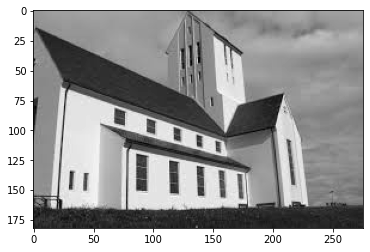

In [76]:
edge_detector.to_gray_scale()
edge_detector.show_plot()

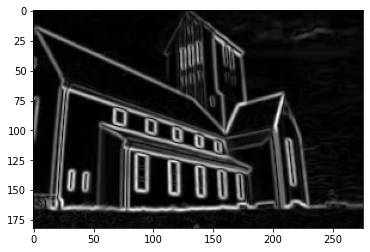

In [77]:
Ix, Iy = edge_detector.spatial_derivative()
M = edge_detector.gradient_magnitude(Ix, Iy)
plt.imshow(M, cmap = plt.get_cmap('gray'))

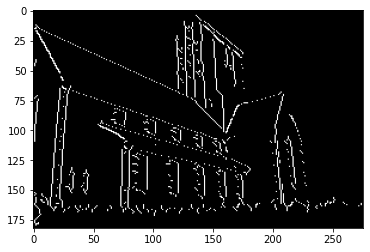

In [78]:
grad_dir_lst = edge_detector.map_gradient_direction(Ix, Iy)
local_max = edge_detector.find_local_max(M, grad_dir_lst)
edge = edge_detector.hysteresis_thresholding(local_max)
plt.imshow(edge, cmap = plt.get_cmap('gray'))

In [79]:
bulr_img = edge_detector.gaussian_filter()

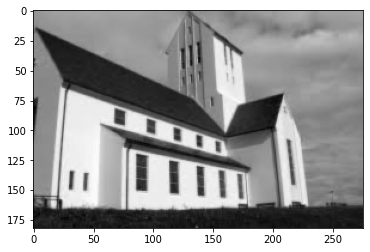

In [80]:
plt.imshow(bulr_img, cmap = plt.get_cmap('gray'))

### Implement Harris Corner Detection algorithm described in the class. Apply your program to detect corners in image 1.

In [81]:
class Corner_detector(Detector):
    def __init__(self, k, img, sigma, threshold_ratio, suppression_radius, response_window_size, gaussian_kernel_size):
        super(Corner_detector, self).__init__(img, sigma, gaussian_kernel_size)
        self.k = k
        self.threshold_ratio = threshold_ratio
        self.suppression_radius = suppression_radius
        self.response_window_size = response_window_size


    def response_calculate(self, Ix, Iy):
        response = np.zeros(self.img.shape)

        Ix_2 = Ix ** 2
        Iy_2 = Iy ** 2

        IxIy = Ix * Iy
        IyIx = Iy * Ix

        offset = int(self.response_window_size / 2)

        for y in range (offset, self.img.shape[0] - offset):
            for x in range (offset, self.img.shape[1] - offset):
                w_Ix_2 = Ix_2[y - offset : y + offset + 1, x - offset : x + offset + 1]
                w_Iy_2 = Iy_2[y - offset : y + offset + 1, x - offset : x + offset + 1]

                w_IxIy = IxIy[y - offset : y + offset + 1, x - offset : x + offset + 1]
                # w_IyIx = IyIx[y - offset : y + offset + 1, x - offset : x + offset + 1]

                det = (w_Ix_2.sum() * w_Iy_2.sum()) - (w_IxIy.sum() ** 2)

                trace = w_Ix_2.sum() + w_Iy_2.sum()

                r = det - self.k * (trace ** 2)

                response[y][x] = r

        return response/np.max(response)

    def non_maximum_suppression(self, response):
        threshold = np.max(response) * self.threshold_ratio
        offset = int(self.suppression_radius / 2)

        for y in range (offset, response.shape[0] - offset):
            for x in range (offset, response.shape[1] - offset):   
                window = response[y - offset : y + offset + 1, x - offset : x + offset + 1]
                max_corner = np.max(window)

                if (max_corner > threshold):
                    for i in range(y - offset, y + offset + 1):
                        for j in range (x - offset, x + offset + 1):
                            if (response[i][j] != max_corner):
                                response[i][j] = 0
                else:
                    response[y][x] = 0

        corner_x_list = []
        corner_y_list = []
        for y in range(response.shape[0]):
            for x in range(response.shape[1]):
                if (response[y][x] > threshold):
                    corner_x_list.append(x)
                    corner_y_list.append(y)

        return response, corner_x_list, corner_y_list

In [82]:
corner_detector = Corner_detector(
    k = 0.05,
    sigma = 1,
    img = image, 
    gaussian_kernel_size = 5, 
    response_window_size = 10, 
    threshold_ratio = 0.01,
    suppression_radius = 10)

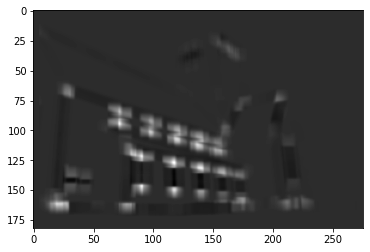

In [83]:
corner_detector.to_gray_scale()
Ix, Iy = corner_detector.spatial_derivative()

response = corner_detector.response_calculate(Ix, Iy)
plt.imshow(response, cmap = plt.get_cmap('gray'))

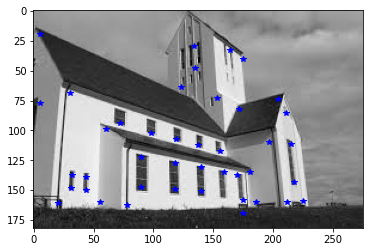

In [84]:
_, corner_x_list, corner_y_list = corner_detector.non_maximum_suppression(response)
plt.plot(corner_x_list,corner_y_list, "b*")
plt.imshow(image, cmap = plt.get_cmap('gray'))